In [1]:
import gc
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

import torch.nn as nn

from tqdm import tqdm

from Data import load_df, RandomSimetry, ChannelJitter, RandomNoise, ImMean as IM, ImSTD as IS
from Network import Unet, ssim_loss

path = "datasets/" + "data6/"
device = "cuda"

IM = IM.to(device)
IS = IS.to(device)

df = load_df(path)

df_z = df[df["mean"] < 0.2].sample(frac=0.2)
df = pd.concat([df[df["mean"] >= 0.2], df_z])

df.head()

,lat,lon,year,month,day,mean,filename
1,-3.59,-54.72,2016,8,1,0.60,Labeled_-3.59_-54.72_2016_08_01_0.60.npy
2,-4.01,-54.76,2021,5,1,0.63,Labeled_-4.01_-54.76_2021_05_01_0.63.npy
7,-4.25,-55.16,2019,8,1,0.39,Labeled_-4.25_-55.16_2019_08_01_0.39.npy
9,-4.31,-54.90,2017,7,1,0.56,Labeled_-4.31_-54.90_2017_07_01_0.56.npy
13,-4.23,-54.68,2017,7,1,0.66,Labeled_-4.23_-54.68_2017_07_01_0.66.npy


In [2]:
class SatelliteDataset(Dataset):
    def __init__(self, path, positions, df, validaion=False):
        self.img_dir = path

        self.positions = positions.copy()
        self.images = df.copy()

        if validaion:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomCrop((64, 64)),
                transforms.Normalize(IM, IS),
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                
                transforms.RandomApply([transforms.RandomRotation(360, interpolation=transforms.InterpolationMode.BILINEAR)], p=0.2),
                
                transforms.RandomCrop((64, 64)),
                transforms.Normalize(IM, IS),
                
                #RandomSimetry(),
                transforms.RandomApply([ChannelJitter(0.2, 0.2)], p=0.2),
                transforms.RandomApply([RandomNoise(0.2)], p=0.2),
            ])

    def __len__(self):
        return self.positions.shape[0]

    def __getitem__(self, idx):
        
        position = self.positions.iloc[idx]
        series = self.images[(self.images["lat"] == position["lat"]) & (self.images["lon"] == position["lon"])]

        filename = series.sample(1)["filename"].values[0]

        img = np.load(self.img_dir + filename)
        img = self.transform(img)

        return img[:-1, :, :].to(device), img[-1, :, :].to(device)

positions = df[["lat", "lon"]].drop_duplicates()

train_positions = positions.sample(frac=0.8)
val_positions   = positions.drop(train_positions.index)

train_ds = SatelliteDataset(path, train_positions, df)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

val_ds = SatelliteDataset(path, val_positions, df, validaion=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=True)

test_dl = DataLoader(train_ds, batch_size=len(val_ds), shuffle=True)

len(train_ds), len(val_ds)

(1196, 299)

tensor([-0.3243, -0.4415, -0.5918, -0.4103, -0.5557, -0.4527, -0.4155],
       device='cuda:0')
tensor([1.7380, 1.5976, 1.2348, 1.1495, 1.1528, 1.0079, 1.0352],
       device='cuda:0')


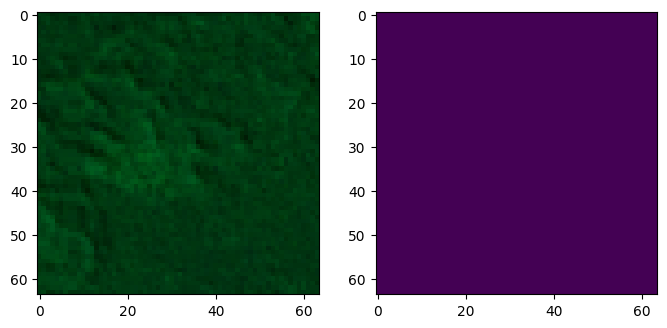

In [3]:
im, lb = next(iter(val_dl))
print(im.mean(dim=[0,2,3]))
print(im.std(dim=[0,2,3]))

image = (im[0][3:6] * IS[3:6, None, None]) + IM[3:6, None, None]
label = lb[0]

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
axes[0].imshow(image.permute(1, 2, 0).clip(0,1).cpu().numpy())
axes[1].imshow(label.cpu().numpy());

In [4]:
#https://www.mdpi.com/2079-9292/11/1/130
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        self.unet = Unet(7, 16, attention=True)

        self.conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            #nn.Sigmoid() # Sigmoid is included in the loss

        )

    def forward(self, x):

        x = self.unet(x)
        x = self.conv(x)

        if not self.training:
            x *= 100000
    
        #x = nn.functional.interpolate(x, scale_factor=0.25, mode="bilinear", align_corners=False)
        #x = nn.functional.interpolate(x, scale_factor=4, mode="bilinear", align_corners=False)

        return x

    
model = Network().to(device)

In [5]:
#https://stackoverflow.com/questions/67730325/using-weights-in-crossentropyloss-and-bceloss-pytorch
# TODO - Does it work?
Mean = df["mean"].mean()

W1 = 1 / (1 - Mean)
W2 = 1 / Mean

bce_loss = nn.BCEWithLogitsLoss(reduction="none")
bce_weights = lambda output, target: ((W1*target + W2) * bce_loss(output, target)).mean(dim=[1,2,3])
bce_ssim = lambda output, target: bce_weights(output, target) + 1.0 * ssim_loss(torch.sigmoid(output), target)

#def gauss_bce(output, target):
#    o = nn.functional.interpolate(output, scale_factor=0.5, mode="bilinear", align_corners=True)
#    t = nn.functional.interpolate(target, scale_factor=0.5, mode="bilinear", align_corners=True)
#
#    loss = bce_ssim(o, t)
    
def bce_ssim_clean(output, target):
    loss = bce_ssim(output, target)
    mean = loss.mean()
    std  = loss.std()

    idx = torch.where(loss > mean + 1*std)[0]
    loss[idx] = 0
    
    return loss * 16 / (16 - len(idx))

Mean, W1, W2

(0.3606964998825464, 1.5642022917382414, 2.7724139278469018)

In [6]:
def plot_images():
    model.eval()

    im, lb = next(iter(val_dl))
    lb = lb[:, None, ...]
    out = torch.sigmoid(model(im))

    image = (im[0][3:6] * IS[3:6, None, None]) + IM[3:6, None, None]
    image = image.permute(1, 2, 0).clip(0,1).cpu().numpy()

    label = lb[0][0].cpu().numpy()
    output = out[0][0].detach().cpu().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    axes[0].imshow(image)
    axes[1].imshow(label)
    axes[2].imshow(output)
    plt.show()

    model.train()

In [7]:
def f1_score(dl):
    model.eval()

    im, lb = next(iter(dl))

    label = lb[:, None, ...]
    output = torch.sigmoid(model(im))

    tp = torch.sum(output * label)
    fp = torch.sum(output * (1-label))
    fn = torch.sum((1-output) * label)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    f1 = 2 * (precision * recall) / (precision + recall)
    
    union = tp + fp + fn
    iou = tp / union # recall / (recall + 1) ?
    
    model.train()

    return float(f1), float(iou)

  0%|          | 0/5001 [00:00<?, ?it/s]

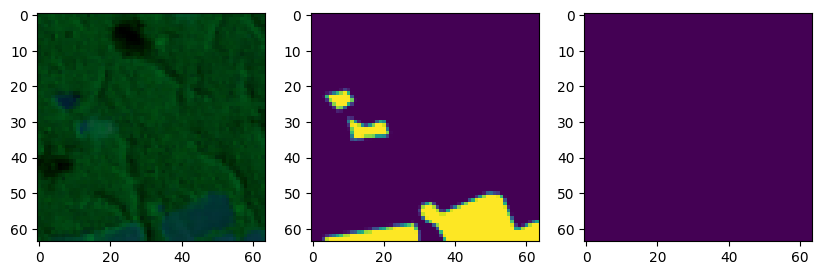

Loss: 0.8922:  10%|▉         | 500/5001 [00:42<05:35, 13.42it/s]

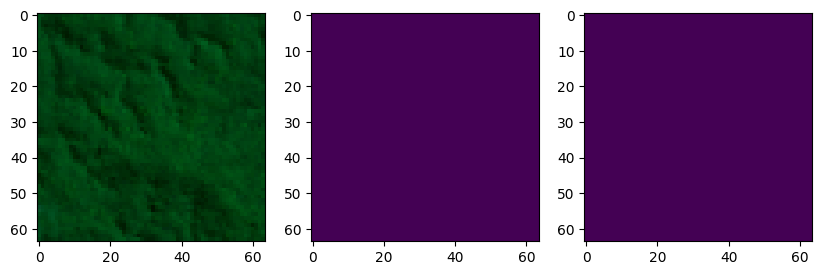

Loss: 0.8803:  20%|█▉        | 1000/5001 [01:25<04:55, 13.54it/s]

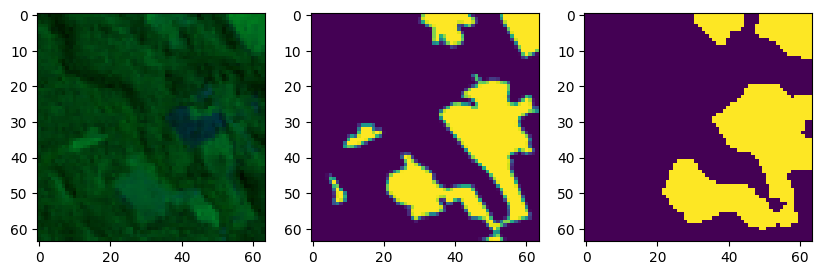

Loss: 0.7398:  30%|██▉       | 1500/5001 [02:08<04:18, 13.55it/s]

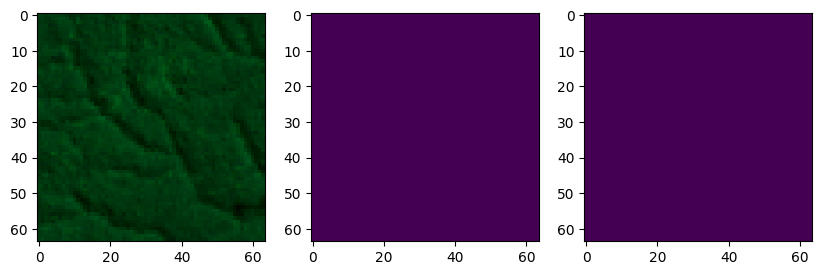

Loss: 0.6036:  40%|███▉      | 2000/5001 [02:50<03:43, 13.45it/s]

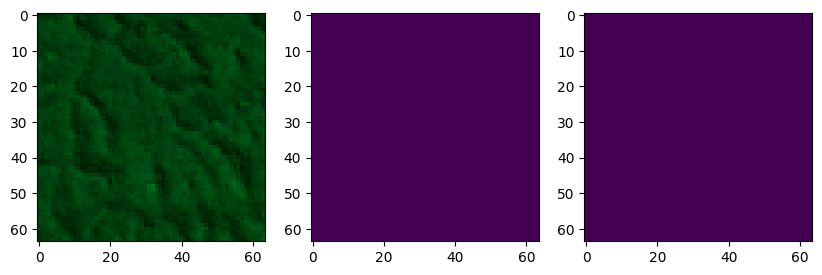

Loss: 0.8103:  50%|████▉     | 2500/5001 [03:33<03:04, 13.55it/s]

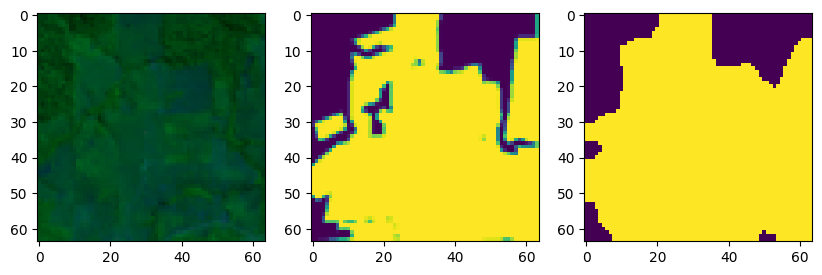

Loss: 0.5266:  60%|█████▉    | 3000/5001 [04:15<02:28, 13.51it/s]

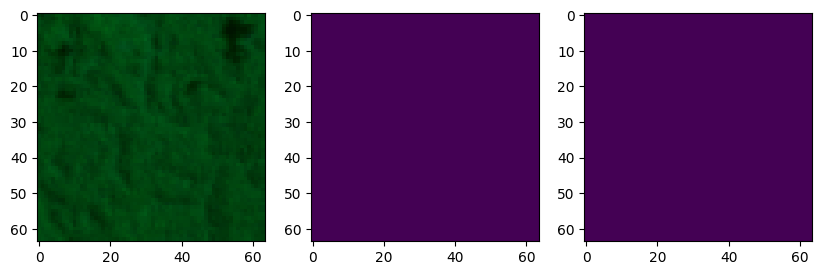

Loss: 0.6581:  70%|██████▉   | 3500/5001 [04:58<01:50, 13.54it/s]

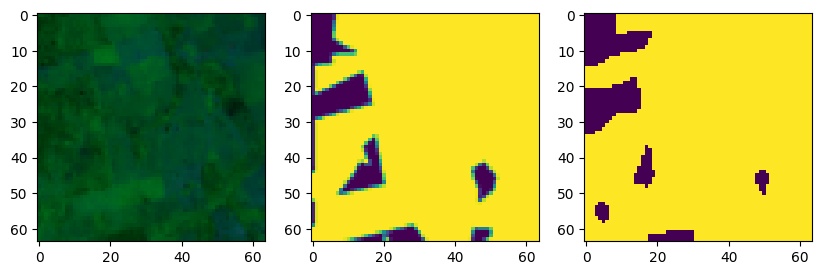

Loss: 0.5088:  80%|███████▉  | 4000/5001 [05:41<01:14, 13.48it/s]

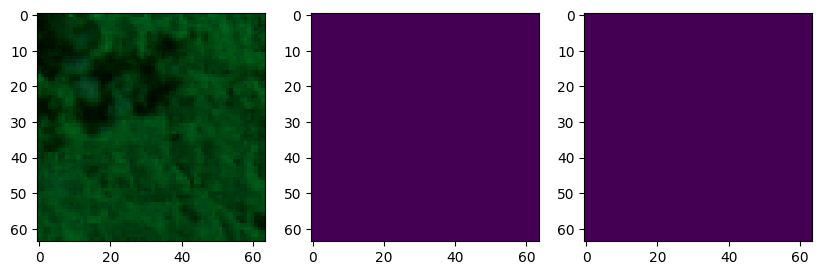

Loss: 0.8469:  90%|████████▉ | 4500/5001 [06:23<00:37, 13.44it/s]

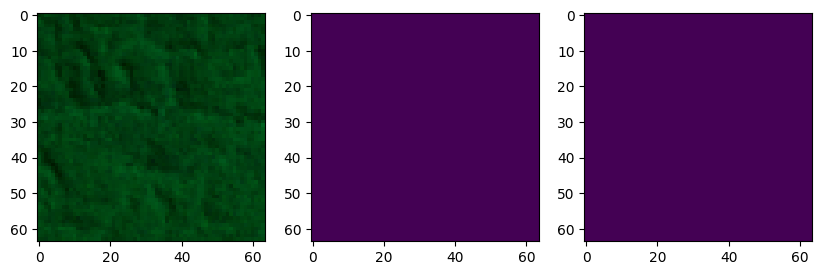

Loss: 0.5284: 100%|█████████▉| 5000/5001 [07:06<00:00, 13.58it/s]

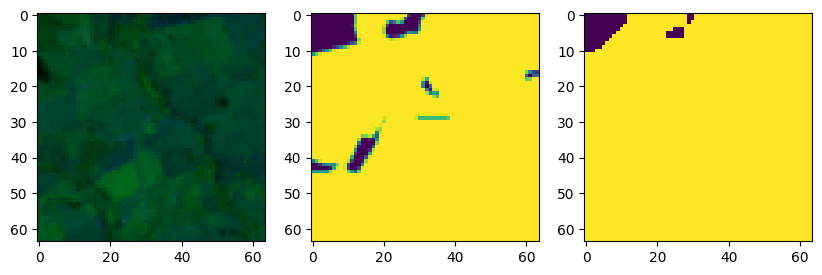

Loss: 0.4430: 100%|██████████| 5001/5001 [07:08<00:00, 11.68it/s]


In [8]:
model.train()
loss_fn = bce_ssim
optimizer = torch.optim.Adam(model.parameters(), lr=0.5e-3)

pbar = tqdm(range(5001), miniters=5)
def closure():
    global pbar, optimizer, loss_fn

    optimizer.zero_grad()

    im, lb = next(iter(train_dl))
    lb = lb[:, None, ...]

    out = model(im)
    loss = loss_fn(out, lb).mean()
    
    loss.backward()

    pbar.set_description(f"Loss: {loss:.4f}", refresh=False)
    return loss

val_losses = []
train_losses = []

model.train()
for i in pbar:
    #if i == 2500:
    #    loss_fn = bce_ssim_clean

    if i % 100 == 0:
        with torch.no_grad():
            gc.collect()
            torch.cuda.empty_cache()

            if i % 500 == 0:
                plot_images()
                gc.collect()
                torch.cuda.empty_cache()
            
            val_losses.append(f1_score(val_dl))
            gc.collect()
            torch.cuda.empty_cache()

            train_losses.append(f1_score(test_dl))        
            gc.collect()
            torch.cuda.empty_cache()

    optimizer.step(closure)

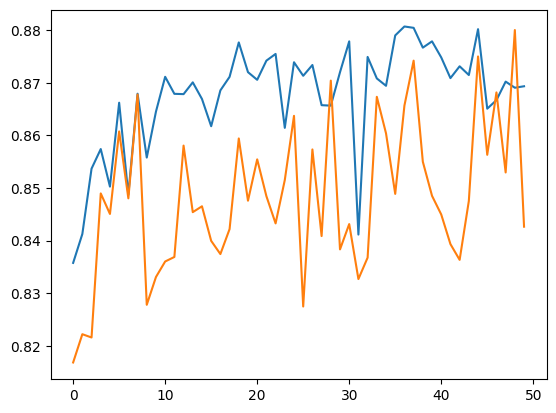

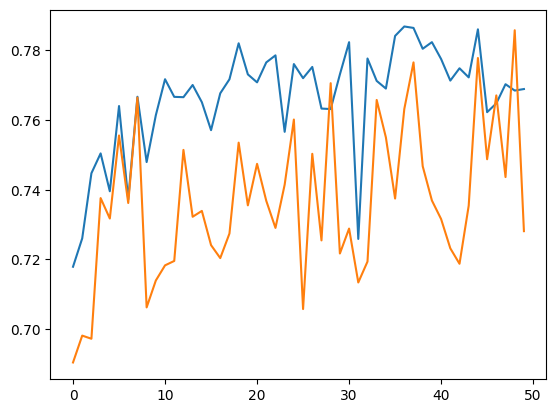

In [9]:
val_f1 = [x[0] for x in val_losses]
val_iou = [x[1] for x in val_losses]

train_f1 = [x[0] for x in train_losses]
train_iou = [x[1] for x in train_losses]

# plot val_losses, train_losses on the same plot
plt.plot(val_f1[1:]) # azul
plt.plot(train_f1[1:]) # laranja
plt.show()

plt.plot(val_iou[1:]) # azul
plt.plot(train_iou[1:]) # laranja
plt.show()

0.8696045517921448


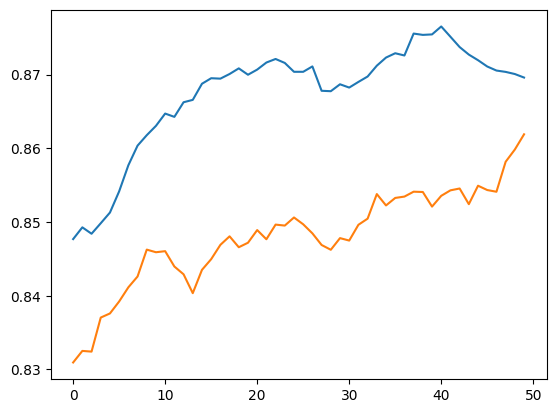

In [10]:
from scipy.ndimage import uniform_filter1d

aa = np.array(val_f1[1:])
aa = uniform_filter1d(aa, size=10)
plt.plot(aa)
print(aa[-1])

aa = np.array(train_f1[1:])
aa = uniform_filter1d(aa, size=10)
plt.plot(aa)


In [11]:
def loss_weight2(output, target):
    loss = bce_weights(output, target)
    mean = loss.mean()
    std  = loss.std()

    #loss > mean + 2*std
    idx = torch.where(loss > mean + 2*std)[0]
    #idx = torch.argsort(loss, dim=0)[-4:]
    print(loss)
    if (len(idx) > 0):
        print("Eliminated:", float(loss.mean()), float(loss.std()), len(idx))

    loss[idx] = 0
    
    for i in idx:
        print(i)
        fig, axes = plt.subplots(1, 3, figsize=(10, 10))
        axes[0].imshow(im[i][[0,1,2]].permute(1, 2, 0).clip(0,1).cpu().numpy())
        axes[1].imshow(label[i][0].cpu().numpy())
        axes[2].imshow(torch.sigmoid(output[i][0].detach()).cpu().numpy())
        plt.show()
    
    
    return loss.mean() * 16 / (16 - len(idx))

tensor([0.5108, 2.7314, 1.0549, 1.6489, 1.7014, 0.0042, 0.0054, 0.4474, 0.6454,
        1.7686, 0.0210, 0.2368, 0.0056, 0.8345, 0.0047, 0.6835, 0.1378, 1.9029,
        0.0042, 0.0044, 0.0036, 0.3802, 0.0051, 0.0165, 0.0040, 0.1934, 0.5478,
        0.0041, 0.0036, 0.0037, 0.0055, 0.0042], device='cuda:0',
       grad_fn=<MeanBackward1>)
Eliminated: 0.48517367243766785 0.7184730172157288 1
tensor(1, device='cuda:0')


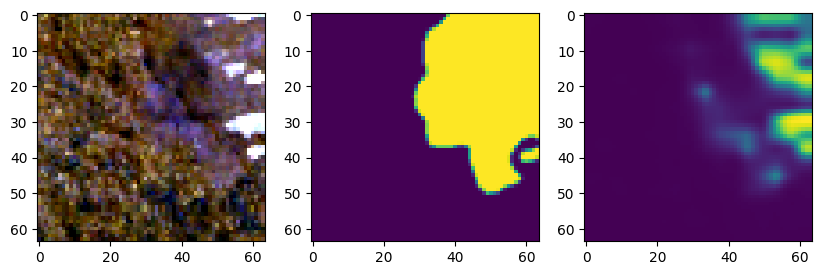

array(0.42647147, dtype=float32)

In [12]:
model.train()

im, lb = next(iter(train_dl))

label = lb[:, None, ...]
output = model(im)
im = (im * IS[:-1, None, None]) + IM[:-1, None, None]
im = im - im.mean(dim=[0,2,3], keepdim=True)
im = im / im.std(dim=[0,2,3], keepdim=True)
im += 0.5

loss = loss_weight2(output, label).cpu().detach().numpy()

model.train()
del im, lb, label, output
gc.collect()
torch.cuda.empty_cache()

loss

In [13]:
torch.save(model.state_dict(), "model4.pt")

In [14]:
torch.softmax(torch.tensor([[0.1, -2, 0.3, 3]]), dim=0)

tensor([[1., 1., 1., 1.]])